<a href="https://colab.research.google.com/github/Yosri15/Loan_Approval_Prediction/blob/main/Loan_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=074a1d7616b7e5b2fbb252aba7bab7e1a7c8febf94b831f58b545998ccf4c8d8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [54]:
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement et Modélisation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
# Modèles avancés
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Interprétabilité du modèle
import lime
import lime.lime_tabular


In [4]:
#Chargement des données
df_train = pd.read_csv('/content/drive/MyDrive/Projet Loan/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Projet Loan/test.csv')
df_sub = pd.read_csv('/content/drive/MyDrive/Projet Loan/sample_submission.csv')
df_origi = pd.read_csv('/content/drive/MyDrive/Projet Loan/credit_risk_dataset.csv')

In [5]:
df_origi.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
df_origi.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [7]:
df_origi.shape

(32581, 12)

In [8]:
df_train.shape

(58645, 13)

In [9]:
# Afficher les premières lignes de la base de données
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [10]:
#Exploration des données
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [11]:
df_train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [12]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [13]:
df_sub.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


In [14]:
# Vérifier les valeurs manquantes
df_train.isnull().sum()

,0
id,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0


In [15]:
# Suppression de la colonne 'id' inutile pour l'analyse
df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

In [16]:
df_train.shape,df_test.shape

((58645, 12), (39098, 11))

In [17]:
# Fusion avec le dataset original pour enrichir les données
df_train = pd.concat([df_train, df_origi], axis=0)

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


In [19]:
df_train.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_percent_income,0
cb_person_default_on_file,0


In [20]:
df_test.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0
cb_person_default_on_file,0


In [21]:
# Remplissage des valeurs manquantes
df_train['person_emp_length'] = df_train['person_emp_length'].fillna(df_train['person_emp_length'].mean())
df_train['loan_int_rate'] = df_train['loan_int_rate'].fillna(df_train['loan_int_rate'].mean())

In [22]:
df_train.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0
cb_person_default_on_file,0


In [23]:
df_train['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
0,0.830553
1,0.169447


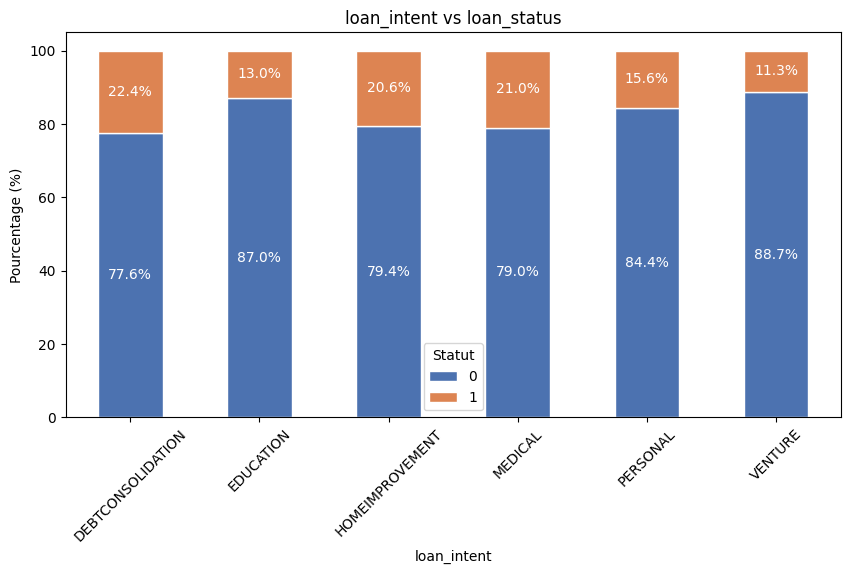

In [24]:
def stacked_bar_plot(df, feature, target='loan_status'):

    crosstab = pd.crosstab(df[feature], df[target], normalize='index') * 100
    ax = crosstab.plot(kind='bar', stacked=True, color=['#4c72b0','#dd8452'],
                       figsize=(10,5), edgecolor='w')
    for bar in ax.containers:
        labels = [f'{h:.1f}%' if h > 0 else '' for h in bar.datavalues]
        ax.bar_label(bar, labels=labels, label_type='center', color='w')
    plt.title(f'{feature} vs {target}')
    plt.xticks(rotation=45)
    plt.ylabel('Pourcentage (%)')
    plt.legend(title='Statut')
    plt.show()

stacked_bar_plot(df_train, 'loan_intent')


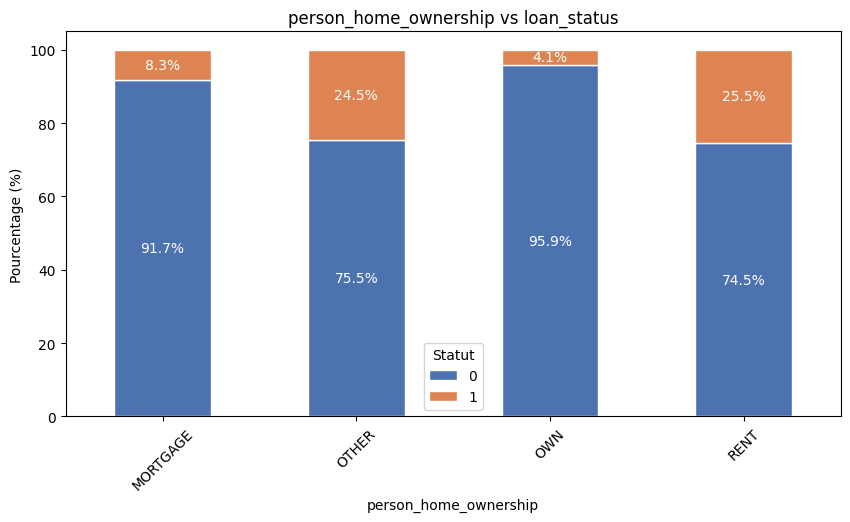

In [25]:
stacked_bar_plot(df_train, 'person_home_ownership')

<ipython-input-26-cf7d143000a5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='person_home_ownership', palette='rocket', order=df_train['person_home_ownership'].value_counts().index)


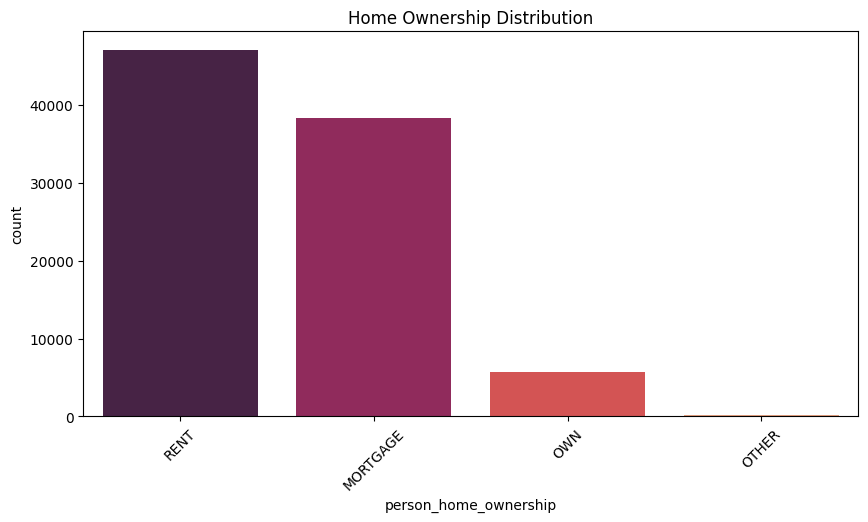

In [26]:
# Répartition des prêts par type de logement
plt.figure(figsize=(10,5))
sns.countplot(data=df_train, x='person_home_ownership', palette='rocket', order=df_train['person_home_ownership'].value_counts().index)
plt.title('Home Ownership Distribution')
plt.xticks(rotation=45)
plt.show()

<ipython-input-27-d1801c855184>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='loan_intent', palette='coolwarm', order=df_train['loan_intent'].value_counts().index)


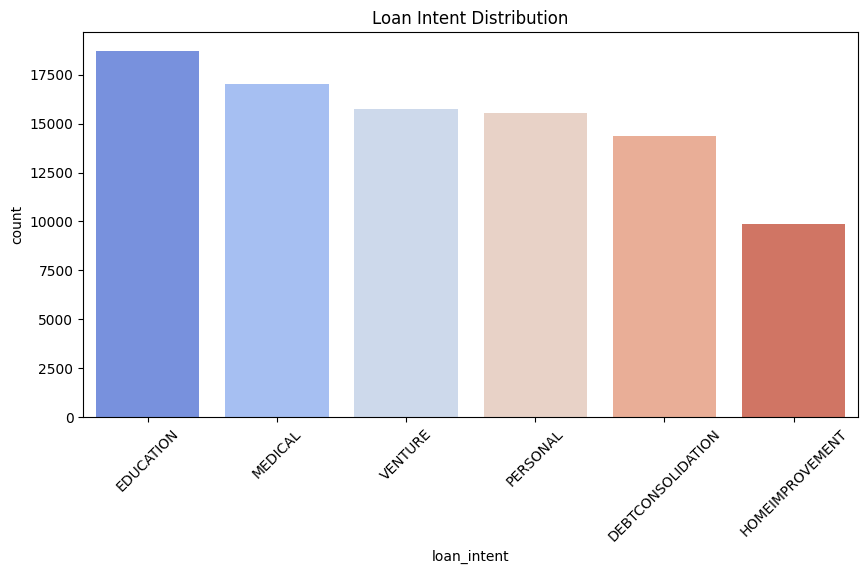

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_train, x='loan_intent', palette='coolwarm', order=df_train['loan_intent'].value_counts().index)
plt.title('Loan Intent Distribution')
plt.xticks(rotation=45)
plt.show()

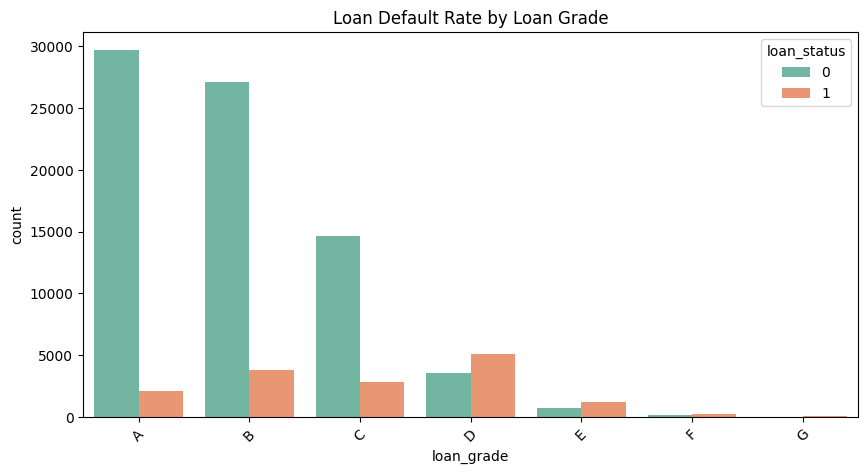

In [28]:
# Taux de défaut selon la note de prêt
plt.figure(figsize=(10,5))
sns.countplot(data=df_train, x='loan_grade',hue='loan_status', palette='Set2', order=df_train['loan_grade'].value_counts().index)
plt.title('Loan Default Rate by Loan Grade')
plt.xticks(rotation=45)
plt.show()

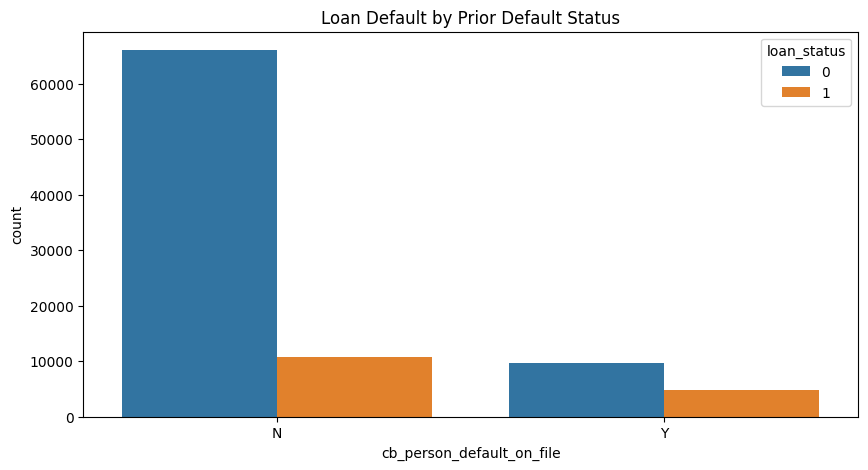

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_train, x='cb_person_default_on_file', hue='loan_status', order=df_train['cb_person_default_on_file'].value_counts().index)
plt.title('Loan Default by Prior Default Status')
plt.show()

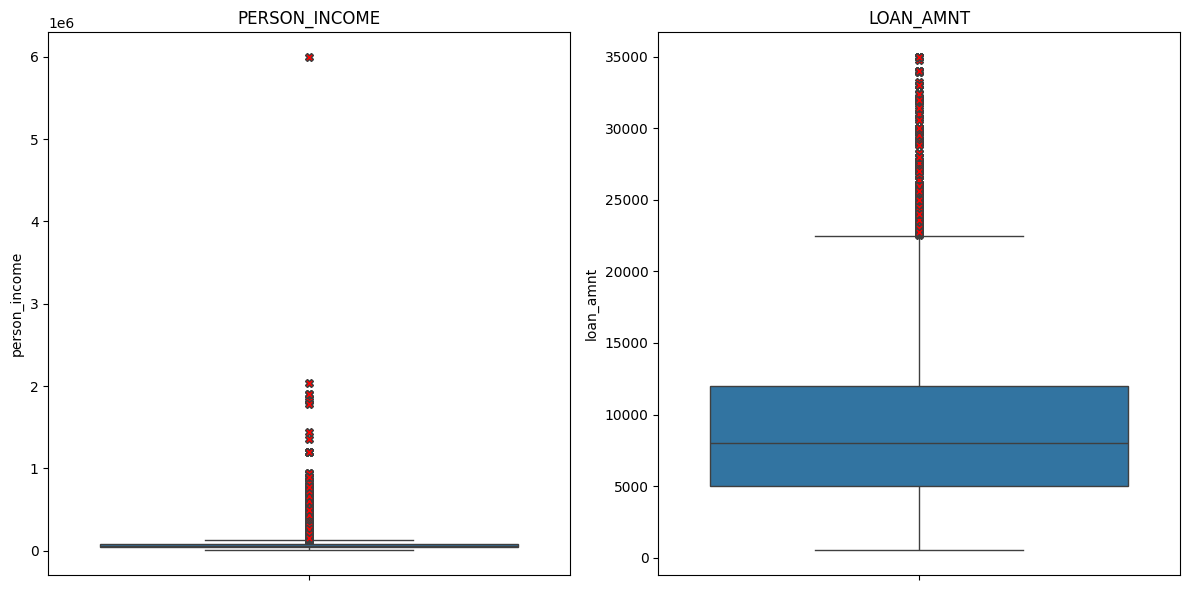

In [30]:
def plot_boxplots(df, columns):
    """Affiche des boxplots pour détecter les valeurs extrêmes"""
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        sns.boxplot(y=df[col], color='#1f77b4',
                    flierprops={'marker': 'X', 'markerfacecolor': 'red', 'markersize': 6})
        plt.title(col.upper())
    plt.tight_layout()
    plt.show()

plot_boxplots(df_train, ['person_income', 'loan_amnt'])


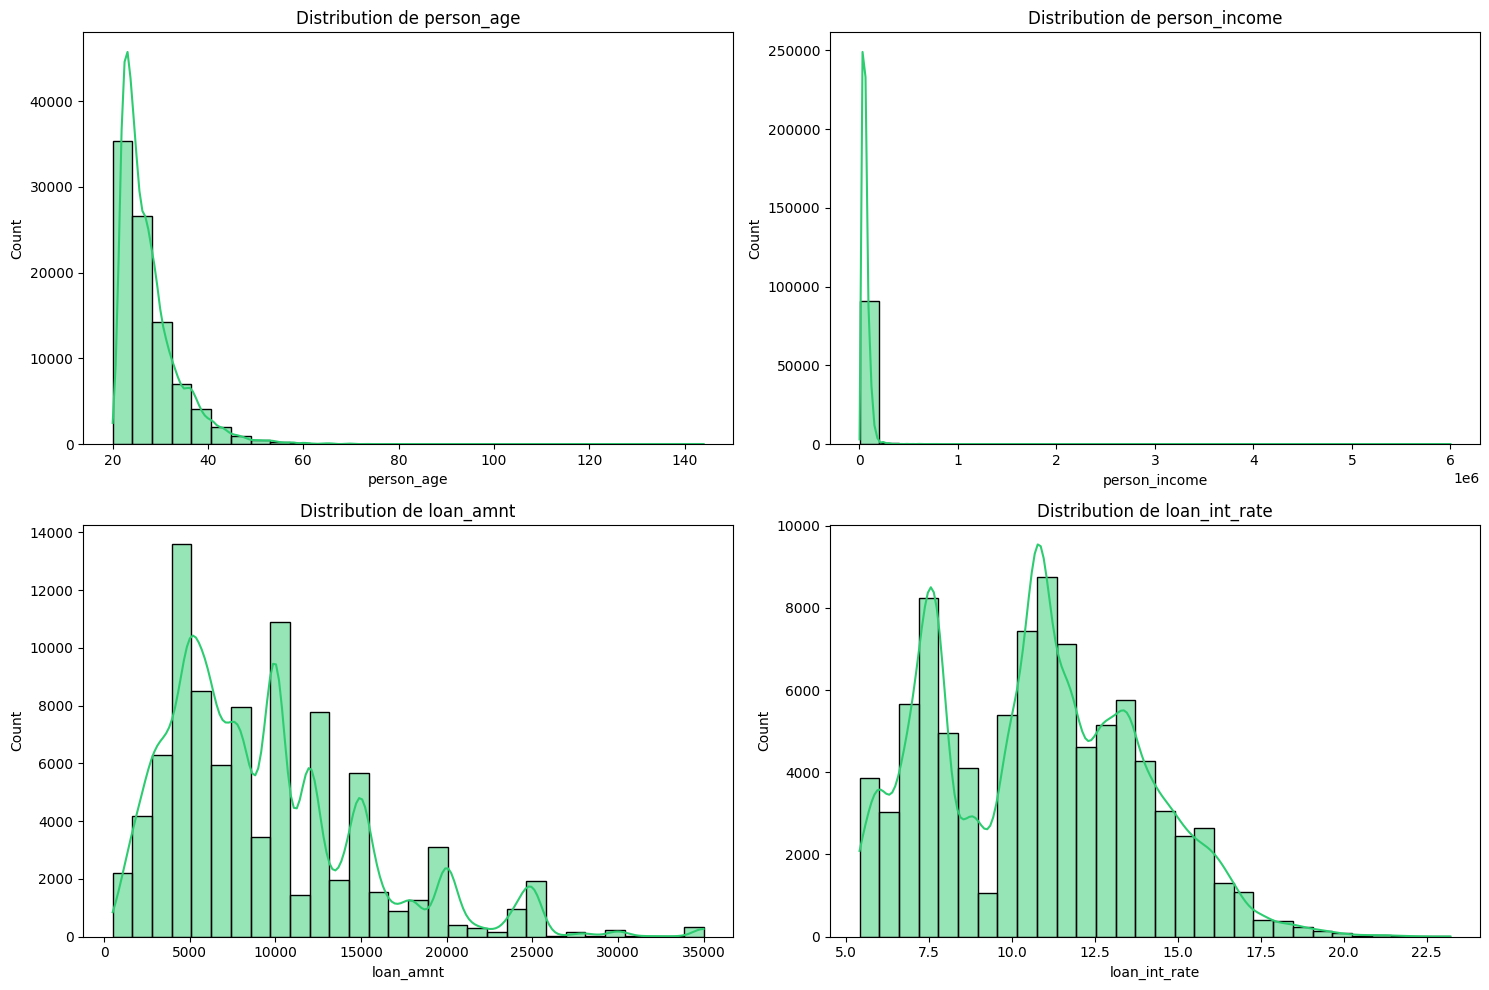

In [31]:
num_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_train[feature], bins=30, kde=True, color='#2ecc71')
    plt.title(f'Distribution de {feature}')
plt.tight_layout()
plt.show()


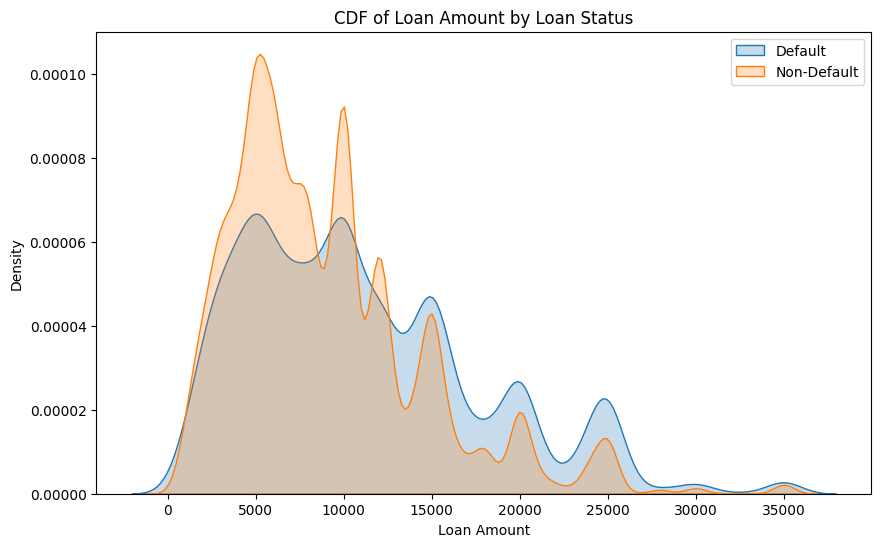

In [32]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train[df_train['loan_status'] == 1]['loan_amnt'], label='Default', fill=True)
sns.kdeplot(df_train[df_train['loan_status'] == 0]['loan_amnt'], label='Non-Default', fill=True)
plt.title('CDF of Loan Amount by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

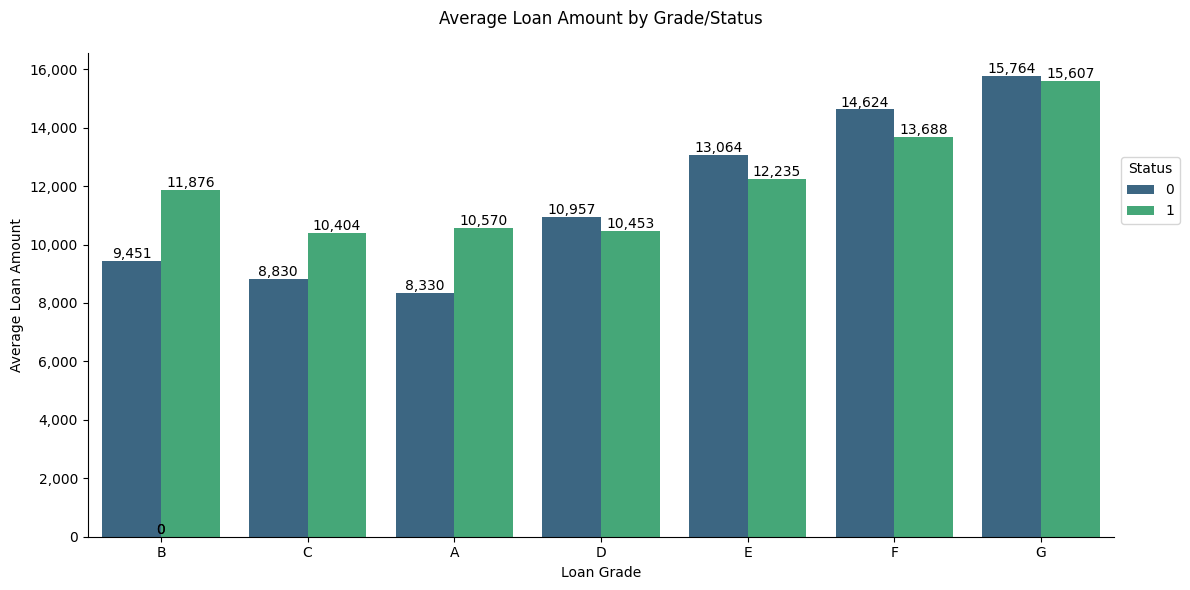

In [33]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='loan_grade', y='loan_amnt', hue='loan_status', data=df_train,
                estimator=np.mean, palette='viridis', errorbar=None)

[ax.annotate(f"{p.get_height():,.0f}", (p.get_x()+p.get_width()/2, p.get_height()),
            ha='center', va='center', xytext=(0,5), textcoords='offset points') for p in ax.patches]

plt.title('Average Loan Amount by Grade/Status\n', fontsize=12)
plt.xlabel('Loan Grade'); plt.ylabel('Average Loan Amount')
plt.legend(title='Status', bbox_to_anchor=(1, 0.8))
plt.gca().yaxis.set_major_formatter('{x:,.0f}'); sns.despine(); plt.tight_layout(); plt.show()

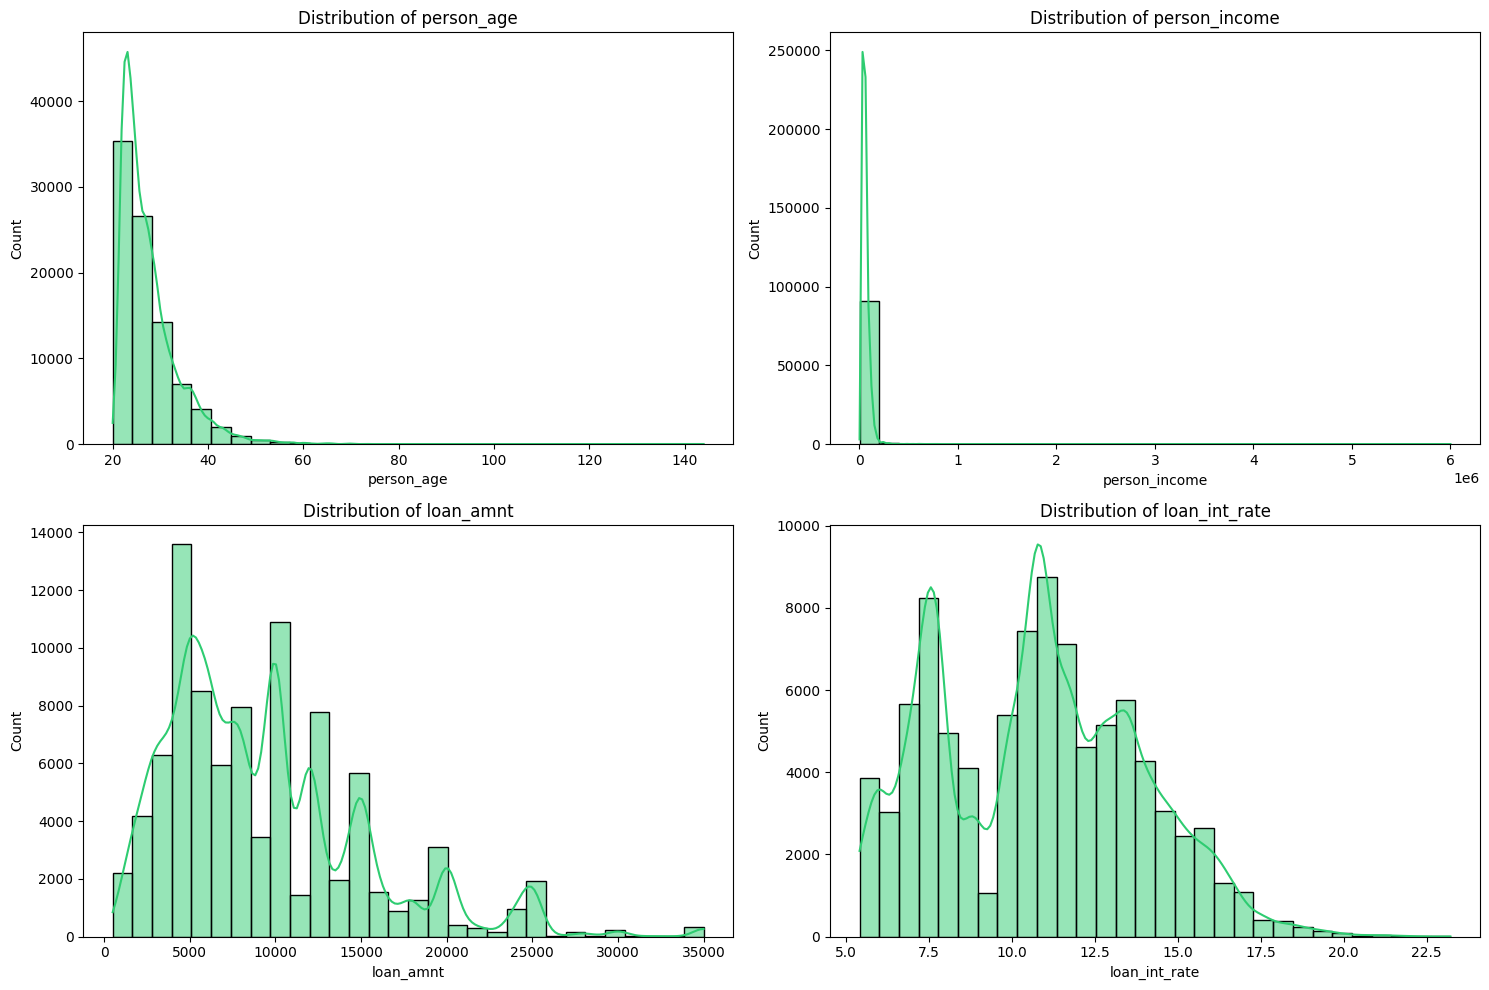

In [34]:
num_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_train[feature], bins=30, kde=True, color='#2ecc71')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

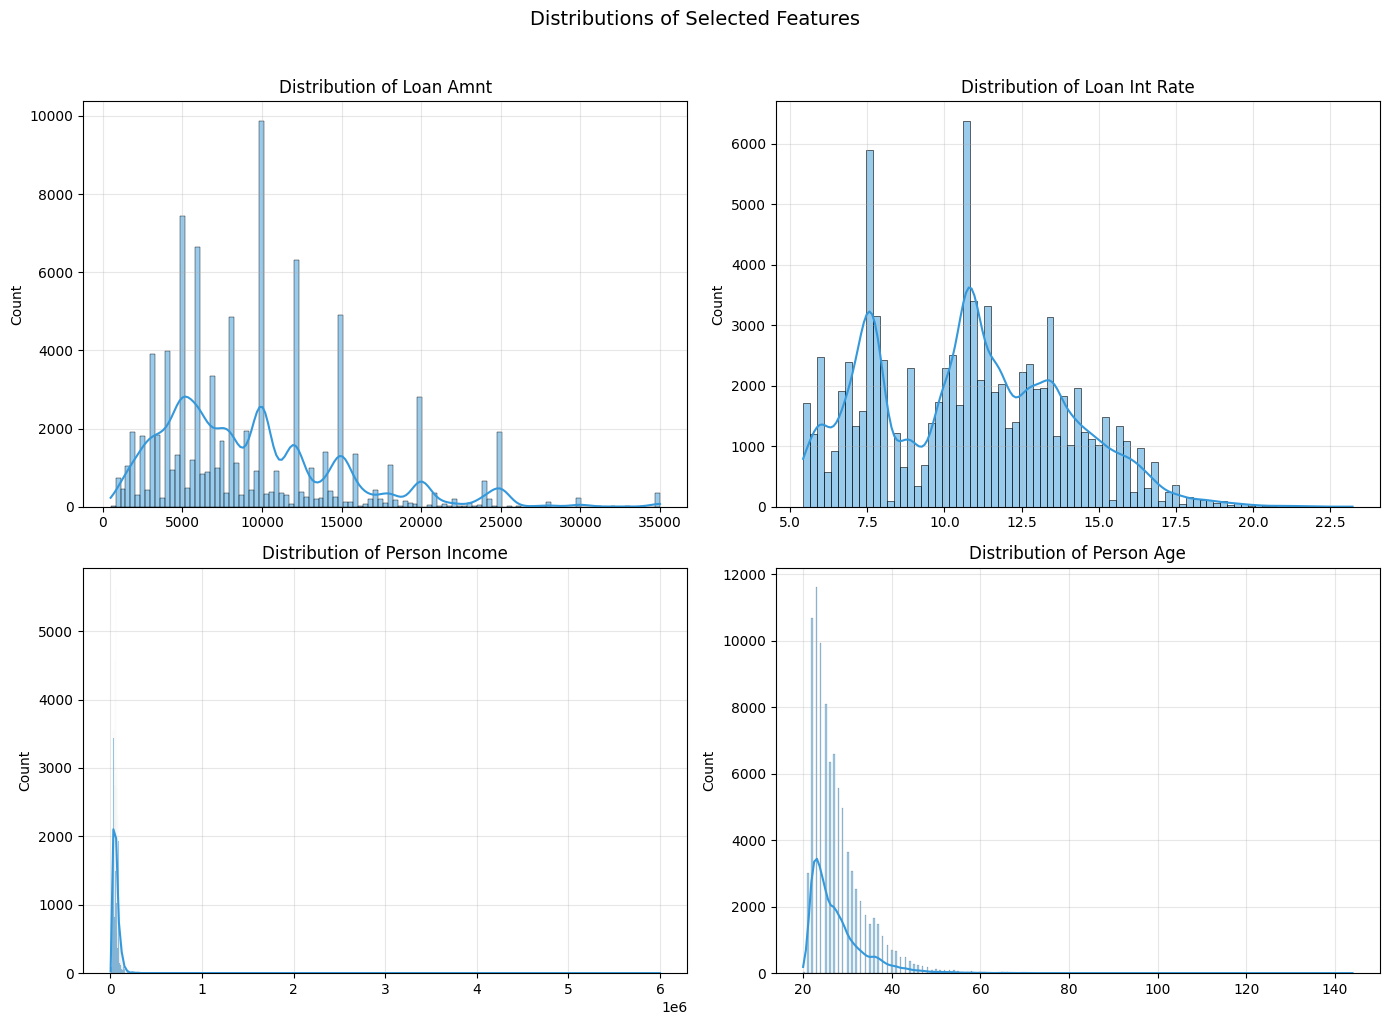

In [35]:
features_to_plot = ['loan_amnt', 'loan_int_rate', 'person_income', 'person_age']

plt.figure(figsize=(14, 10))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df_train, x=col, kde=True, color='#3498db', edgecolor='black')
    plt.title(f'Distribution of {col.replace("_", " ").title()}', fontsize=12)
    plt.xlabel('')
    plt.grid(alpha=0.3)
plt.suptitle('Distributions of Selected Features', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [36]:
def preprocess_data(df_train, df_test):
    label_enc = LabelEncoder()
    label_cols = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']
    for col in label_cols:
        df_train[col] = label_enc.fit_transform(df_train[col])
        df_test[col] = label_enc.transform(df_test[col])

    df_train = pd.get_dummies(df_train, columns=['loan_intent'], drop_first=True)
    df_test = pd.get_dummies(df_test, columns=['loan_intent'], drop_first=True)

    target_col = 'loan_status'
    train_columns = df_train.drop(columns=[target_col]).columns
    df_test = df_test.reindex(columns=train_columns, fill_value=0)
    return df_train, df_test

df_train_processed, df_test_processed = preprocess_data(df_train, df_test)

In [37]:
df_train = df_train_processed
df_test = df_test_processed

In [38]:
df_train.shape,df_test.shape

((91226, 16), (39098, 15))

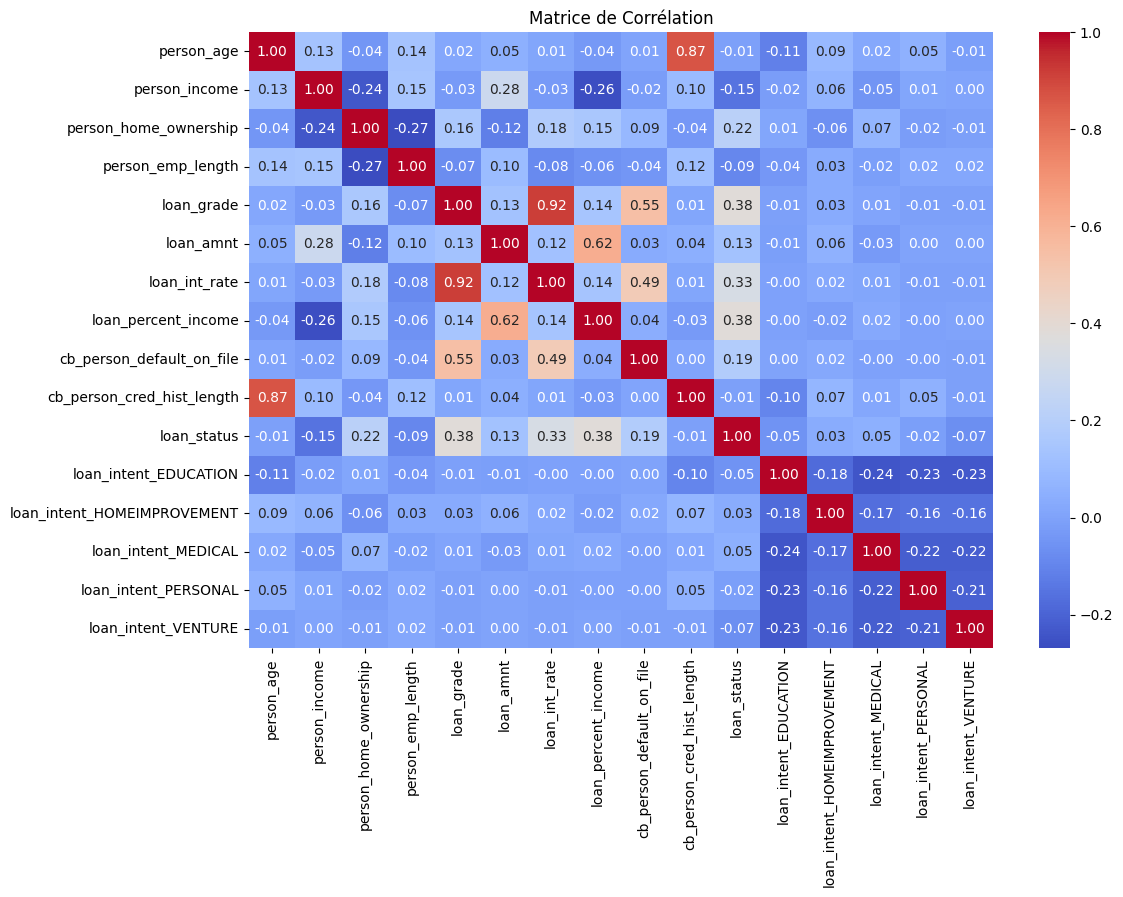

In [46]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de Corrélation")
plt.show()

In [49]:
def feature_engineering(df):
    # Rapport entre le montant du prêt et le revenu de la personne (plus il est élevé, plus la personne est "chargée")
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

    # Charge financière totale = montant du prêt * taux d'intérêt (montant global que la personne devra rembourser en intérêts)
    df['financial_burden'] = df['loan_amnt'] * df['loan_int_rate']

    # Revenu par année d'expérience professionnelle (est-ce que la personne gagne bien par rapport à son ancienneté)
    df['income_per_year_emp'] = df['person_income'] / (df['person_emp_length'])

    # Rapport entre la durée de l'historique de crédit et l'âge (est-ce que la personne a été active tôt ou tard)
    df['cred_hist_to_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']

    # Taux d'intérêt divisé par le montant du prêt (est-ce qu'on a donné un prêt avec des intérêts très élevés ou pas)
    df['int_to_loan_ratio'] = df['loan_int_rate'] / df['loan_amnt']

    # Interaction entre taux d’intérêt et ancienneté professionnelle (comportement croisé de deux variables)
    df['loan_int_emp_interaction'] = df['loan_int_rate'] * df['person_emp_length']

    #Ratio dette/crédit = montant du prêt divisé par la durée de l'historique de crédit (est-ce que cette personne emprunte beaucoup par rapport à son expérience avec le crédit)
    df['debt_to_credit_ratio'] = df['loan_amnt'] / df['cb_person_cred_hist_length']

    # Taux d'intérêt divisé par l'historique de crédit (est-ce que ceux avec peu d’expérience paient plus d’intérêts ?)
    df['int_to_cred_hist'] = df['loan_int_rate'] / df['cb_person_cred_hist_length']

    # Taux d’intérêt par année d'expérience (est-ce que les gens plus expérimentés ont de meilleurs taux ?)
    df['int_per_year_emp'] = df['loan_int_rate'] / (df['person_emp_length'])

    # Montant emprunté par année d'expérience professionnelle
    df['loan_amt_per_emp_year'] = df['loan_amnt'] / (df['person_emp_length'])

    # Revenu par rapport au montant emprunté (inverse de loan_to_income_ratio, utile dans certains modèles)
    df['income_to_loan_ratio'] = df['person_income'] / df['loan_amnt']

    return df

df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)


In [52]:
y = df_train['loan_status']
df_train = df_train.drop(['loan_status'],axis=1)
X = df_train

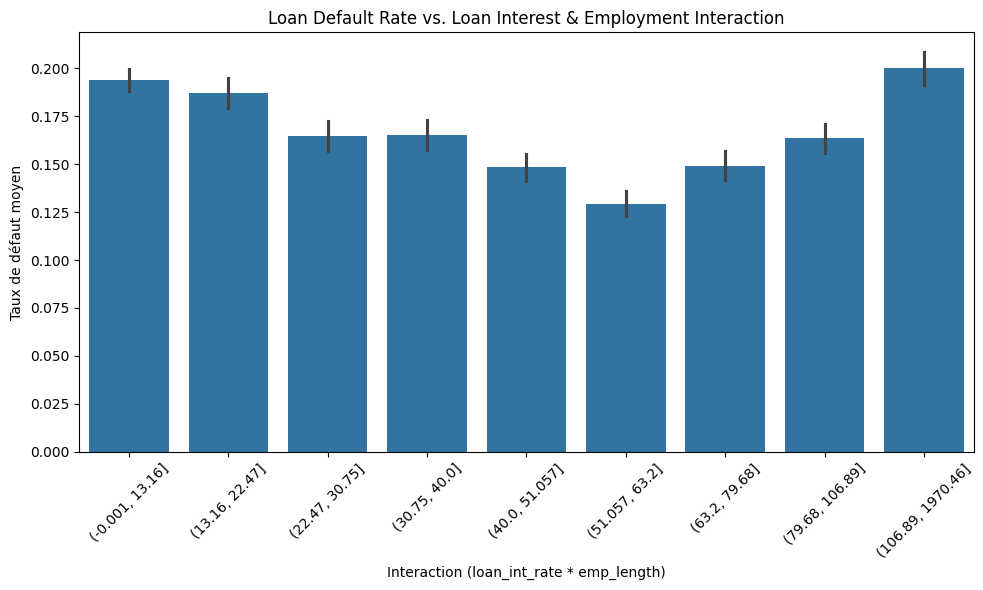

In [51]:
df_train['interaction_bin'] = pd.qcut(df_train['loan_int_emp_interaction'], q=10, duplicates='drop')

# Visualiser le taux de défaut moyen par groupe
plt.figure(figsize=(10,6))
sns.barplot(x='interaction_bin', y='loan_status', data=df_train)
plt.xticks(rotation=45)
plt.title('Loan Default Rate vs. Loan Interest & Employment Interaction')
plt.xlabel('Interaction (loan_int_rate * emp_length)')
plt.ylabel('Taux de défaut moyen')
plt.tight_layout()
plt.show()

# Une interaction trop forte ou  trop faible --> risque

In [55]:
scaler = StandardScaler()
scaled_train_data = df_train
scaled_test_data = df_test